In [1]:
!pwd

/home/ljw/code/nlp/dialogue/transformer


In [2]:
from torch import nn
from config import *
from transformer import TransformerEncoder, TransformerDecoder, EncoderDecoder
from attention import sequence_mask
from data import loaddata, MyDataset, Lang

In [3]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [4]:
from matplotlib import pyplot as plt
import time
from IPython import display
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
#         use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [5]:
import torch.nn.functional as F
def loss_fn(out, tar):
    out = out.contiguous().view(-1, out.shape[-1])
    tar = tar.contiguous().view(-1)
    return F.cross_entropy(out, tar, ignore_index=2)  # pad

In [6]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
            
            
def train_seq2seq(net, data_iter, valid_iter, lr, num_epochs, lang, device, first_train = True, min_ppl=1e9, i = 70):
   # """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss',
                     xlim=[0, num_epochs])
    animator1 = Animator(xlabel='epoch', ylabel='ppl',
                     xlim=[0, num_epochs])
    LOSS = PPL = 0
    
    timer = Timer()
    
    if first_train:
        net.apply(xavier_init_weights)
    else:
        net.eval()
        PPL_AVG = 0
        LOSS_AVG = 0
        with torch.no_grad():
#             i = 0
            for batch in valid_iter:
                # 转device
                X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
                # inputs带<eos>不带<bos>，outputs带<bos>不带<eos>
                # 初始bos
                bos = torch.tensor([2  # lang.word2index['<bos>']
                                    ] * Y.shape[0],
                                   device=device).reshape(-1, 1)
                dec_input = torch.cat([bos, Y[:, :-1]], 1)
                # Teacher forcing, 输入X和正确答案，希望得到正确答案
                # Y_hat
                Y_hat, _ = net(X, dec_input, X_valid_len)
                # Y_hat和Y中都有eos，没有bos
                l = loss_fn(Y_hat, Y)
                ppl = torch.exp(l)
                LOSS_AVG += l.item()
                PPL_AVG += ppl.item()
            PPL_AVG /= len(valid_iter)
            min_ppl = PPL_AVG
            LOSS_AVG /= len(valid_iter)
            
            animator1.add(0, (PPL_AVG, PPL_AVG,))
            animator.add(0, (LOSS_AVG, LOSS_AVG,))
                
    
    for epoch in range(num_epochs):
        
        net.train()
#         lr = 512**(-0.5) * i**(-0.5)
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([2] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss_fn(Y_hat, Y)
            ppl = torch.exp(l)
            l.backward()
#             grad_clipping(net, 20)
            optimizer.step()
            with torch.no_grad():
                LOSS += l.item()
                PPL += ppl.item()
        i += 1
#             if i == 30:
#                 break
        LOSS /= len(data_iter)
        PPL /= len(data_iter)

        
        net.eval()
        PPL_AVG = 0
        LOSS_AVG = 0
        with torch.no_grad():
#             i = 0
            for batch in valid_iter:
                # 转device
                X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
                # inputs带<eos>不带<bos>，outputs带<bos>不带<eos>
                # 初始bos
                bos = torch.tensor([2  # lang.word2index['<bos>']
                                    ] * Y.shape[0],
                                   device=device).reshape(-1, 1)
                dec_input = torch.cat([bos, Y[:, :-1]], 1)
                # Teacher forcing, 输入X和正确答案，希望得到正确答案
                # Y_hat
                Y_hat, _ = net(X, dec_input, X_valid_len)
                # Y_hat和Y中都有eos，没有bos
                l = loss_fn(Y_hat, Y)
                ppl = torch.exp(l)
                LOSS_AVG += l.item()
                PPL_AVG += ppl.item()
#                 i += 1
#                 if i == 10:
#                     break
                    
            PPL_AVG /= len(valid_iter)
            LOSS_AVG /= len(valid_iter)
            if PPL_AVG < min_ppl:
                if min_ppl != 1e9:
                    torch.save(encoder, MODEL_ROOT + "trans_encoder.mdl")
                    torch.save(decoder, MODEL_ROOT + "trans_decoder.mdl")
                min_ppl = PPL_AVG
                
        if (epoch + 1) % 1 == 0:
            
            animator1.add(epoch + 1, (PPL, PPL_AVG,))
            animator.add(epoch + 1, (LOSS, LOSS_AVG,))
            
    print(f'loss {LOSS:.3f}, PPL {PPL:.3f}, {timer.stop()/60:.1f} '
        f'min on {str(device)}')
    print(f'loss {LOSS_AVG:.3f}, PPL {PPL_AVG:.3f} ')
    print(lr)

In [7]:
dataset = torch.load(DATA_ROOT + "dataset")
lang = torch.load(DATA_ROOT + "dialog.lang")
valid_data = torch.load(DATA_ROOT + "validdata")

In [8]:
train_iter = loaddata(dataset, 64)
valid_iter = loaddata(valid_data, 64)

In [11]:
encoder = TransformerEncoder(
        len(lang), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
        num_layers, dropout)
decoder = TransformerDecoder(
        len(lang), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
        num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

In [10]:
encoder = torch.load(MODEL_ROOT + "trans_encoder{}.mdl".format(num_examples))
decoder = torch.load(MODEL_ROOT + "trans_decoder{}.mdl".format(num_examples))
net = EncoderDecoder(encoder, decoder)

FileNotFoundError: [Errno 2] No such file or directory: '../../model/dialog/trans_encoder.mdl'

In [12]:
lr = 0.002

KeyboardInterrupt: 

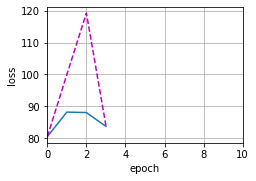

In [16]:
train_seq2seq(net, train_iter, valid_iter, 0.1, 10, lang, device, first_train=True)

In [ ]:
torch.save(encoder, MODEL_ROOT + "trans_encoder{}.mdl".format(num_examples))
torch.save(decoder, MODEL_ROOT + "trans_decoder{}.mdl".format(num_examples))

In [ ]:
train_seq2seq(net, train_iter, valid_iter, 0.00001, 5, lang, device, first_train=False)
torch.save(encoder, MODEL_ROOT + "trans_encoder2{}.mdl".format(num_examples))
torch.save(decoder, MODEL_ROOT + "trans_decoder2{}.mdl".format(num_examples))

loss 1.572, PPL 4.848, 4.0 min on cuda:0
loss 3.388, PPL 30.146 


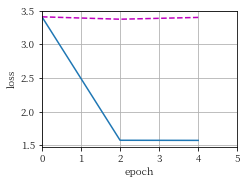

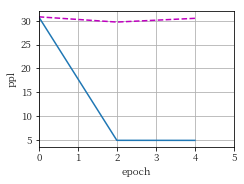

In [17]:
train_seq2seq(net, train_iter, valid_iter, 0.0001, 5, lang, device, first_train=False)
torch.save(encoder, MODEL_ROOT + "trans_encoder2{}.mdl".format(num_examples))
torch.save(decoder, MODEL_ROOT + "trans_decoder2{}.mdl".format(num_examples))

In [ ]:
train_seq2seq(net, train_iter, valid_iter, 0.002, 10, lang, device, first_train=False)
torch.save(encoder, MODEL_ROOT + "trans_encoder2{}.mdl".format(num_examples))
torch.save(decoder, MODEL_ROOT + "trans_decoder2{}.mdl".format(num_examples))

In [ ]:
train_seq2seq(net, train_iter, valid_iter, 0.002, 10, lang, device, first_train=False)
torch.save(encoder, MODEL_ROOT + "trans_encoder2{}.mdl".format(num_examples))
torch.save(decoder, MODEL_ROOT + "trans_decoder2{}.mdl".format(num_examples))

In [14]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

def predict_seq2seq(net, src_sentence, lang, num_steps,
                    device, save_attention_weights=False):
    def voc(line):
        return [lang.word2idx(i) for i in line]

    #"""Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = voc((src_sentence.lower().split())) + [3]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 截断、填充文本序列
    src_tokens = truncate_pad(src_tokens, num_steps, 1)
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
        torch.tensor([2], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)

        dec_X = Y.argmax(dim=2)  # 最大的下标，即为最终词下标
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()  # 去掉第一维取结果
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == 3:
            break
        output_seq.append(pred)
    return ' '.join([lang.index2word[i] for i in output_seq]), attention_weight_seq


In [19]:
while 1:
    sentence = input()
    if sentence == 'q':
        break
    out, weight = predict_seq2seq(net, sentence, lang, num_steps, device)
    print(out)


 hello


i am sorry , sir .


 hi.


i am sorry , sir .


 how are you ?


i think i can ’ t afford it .


 what's matter ?


i think i can ’ t afford it .


 how much ?


i think i can ’ t afford it .


 what ’ s your ideal job ?


i ’ m not sure . i ’ m sure i ’ m sure i ’ m .


 what's your ideal boss ?


i think i can ’ t afford it .


KeyboardInterrupt: Interrupted by user

In [15]:
!nvidia-smi

Wed Nov 30 17:26:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 54%   48C    P8     1W / 250W |   3588MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 27%   